## Mutants:
#### since the discovery of their existence they have been regarded with fear, suspicious, often hatred
Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natural selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


## Solution
The most compact way to implement this using the previous results and defined elements is to implement a more complex structure which can behave differently according to a memory element. This can be done using a class to manage Mutants: a mutant should have a genome which contains the gene that allows him to mutate and determine the nature of the mutation. To simulate this, the Mutant is a guy that is allowed to use some of the previous defined strategies, each one with a defined probability that changes during the match or tournament; to do so it is always allowed to have access to nice_guy and bad_guy, and from those can create mainly_nice, mainly_bad and random. At every moment the class can be called to get a move and the mutate function can be invoked to make it change.
Every mutant can encode its own information via genome, containing information about their genes and their probabilities.
For the evolutionary process no penalty will be provided for a mutant with higher number of genes, because more variety increases also the possibility of "bad" mutations in the future

## Mutant Iterative Tournament
### The transition from classification to individuals
From now on every participant in the tournament will be an individual, a different agent able to perform an unique task.
To do this, every participant, a mutant, is an istance of a class which encodes all the informations needed.

### Genetic information
Each mutant is provided with a list of different strategies form which to chose, taken from the strategy used up to this point (could be the whole list or a subset of those); this rapresents the differnt types of genes used in the species genome.
Each strategy has its own probability of beeing chosen, rapresenting the appearance of each gene in the entire genome.
For each match played, every mutant chose an atomic strategy to follow according to his genetic information.

### Move selection
For each match and each round, a move is chosen according to a defined previous used strategy. Those are considered the atomic strategies and according to the strategy used the next move is chosen (with the same selection process as seen up until this point).
The atomic strategy used in each match is chosen before the start of the match and kept for all the rounds, according to the adaptation to the envinroment.

### Evolution
After each tornament ends, a new generation is created. Most of the mutants present remains but are asked to mutate.
The mutate function is called and its job is to change the probabilty of each strategy in the genome.
The random mutation procedure is performed taking for each probability a Gaussian PDF centered in the previous value and with $\sigma = 0.1$; if the random generated value is below 0 the gene disappears from the list for the next interaction, otherwise all the weights are renormalized to get a cumulative probability of 1. This way each generation has the possibility to activate a quiescient gene or deactivate a low-level gene, also changing the proportion between each strategy.

### Adaptation
During the tournament mutants are able to adapt, changing the strategy they will use during the next match according to the probability in their genome. The chosen strategy is encoded in a parameter selecting the range inside the comulative probabilty of all mutant strategies, and is drawn randomly at the start and then changed with the adapt function. According to the previous match result (win/loss) the mutant change: for a win, a small change is performed using a small deviation gaussian centered into the previous value, to optimize winning strategies, for a loss the strategy is drawn uniformly random.

### Natural selection - Environmental pressure
Another parameter to operate the evolution is the natural selection: all mutants perform in the same tournament, competing against one onother's; the tournament is then iterated a fixed number of time or until a parity is reached.
At each iteration of the tournament a number of the worst mutants are removed from the tournament and are replaced with the same number of copies of the best performed players.
The number of players to replace from top and bottom of the graduatory is the same, and is chosen a priori.

In [21]:
class mutant :

    # allows to switch between random chosen strategy and fixed treshold strategy
    random_strat = False
    
    # allows to change model including or not always Bad Guy and Nice Guy in the schema
    always_NB = False
    
    # CONSTRUCTOR
    # every mutant is created with a name and a list of tuples, containing accessible strategies and their initial weight
    def __init__( self, name, starting_strategy ) : 
        self.name = name
        # the series of trategies that can be chosen, starting from a list of strategies and their probabilities
        self.strategy_dic = { i[0] : strategies[i[0]] for i in starting_strategy } 
        # NiceGuy and BadGuy incarnate the basic behaviour, thus are included as last elements, if not already present, if decided a priori
        if( self.always_NB ) :
            self.strategy_dic[ 'NiceGuy' ] = nice_guy
            self.strategy_dic[ 'BadGuy' ] = bad_guy
        # this process creates an internal dictionary similar to strategies but with limited entries, useful for later cycles
        # the gene in rapresented by the strategy list, a list of values that determine which strategy use to create the next move
        # this is rapresented by a normalized range of values chosen by a uniform distribution
        starting_weight = [ i[1] for i in starting_strategy ]
        self.strategy = np.array( starting_weight/np.sum(starting_weight) )
        # if an empty starting_strategy is passed, the mutant become a random_guy
        if( len(starting_strategy) == 0 ) :
            self.strategy_dic[ 'NiceGuy' ] = nice_guy
            self.strategy_dic[ 'BadGuy' ] = bad_guy
            self.strategy = np.array( [ 0.5, 0.5 ] )
        # reshaping the weight array to consider added elements
        self.strategy.resize( len( self.strategy_dic ) )
        self.dic_keys = list( self.strategy_dic.keys() )
        self.treshold = npr.random( )

    # alternative constructor: it takes genome, a string of gene letters, the ripetition of each means a different probability
    @classmethod
    def from_genome( cls, genome ) :
        g_list = [ ( g, genome.count( g ) ) for g in list( cls.genes.keys() ) if ( genome.count( g ) ) ]
        total_g = sum( [ i[1] for i in g_list ] )
        strategy = [ ( cls.genes[ g[0] ] , float( g[1] ) / float( total_g )  ) for g in g_list ]
        return cls( genome, strategy )
    
    # REPR OUTPUT
    def __repr__( self ) :
        return f"<Mutant name:{self.name} strategy_dic:{self.strategy_dic} strategy:{self.strategy}>"

    # PRINTING OUTPUT
    def __str__( self ) :
        return f"Mutant class:\n   Name: {self.name}\n   Strategies in the genome: {[ i for i in self.strategy_dic]}\n   Gene values: {self.strategy}\n"

    # DEFINING HOW COPY BEHAVE, PREVENTING A SHALLOW COPY
    # def __copy__( self ) :
    #     # returning a new object made from the same basic informations, name and list of couples of name of strategy used and its weight 
    #     return mutant( self.name, { self.dic_keys[i] : self.strategy[i] for i in range(len(self.dic_keys)) } )

    # DEFINING HOW DEEPCOPY BEHAVE, PREVENTING A SHALLOW COPY
    # def __deepcopy__( self, memo ) :
    #     # returning a new object made from the same basic informations, name and list of couples of name of strategy used and its weight 
    #     name = copy.deepcopy( self.name )
    #     dic_keys = copy.deepcopy( self.dic_keys )
    #     strategy = copy.deepcopy( self.strategy )
    #     new = mutant( name, { dic_keys[i] : strategy[i] for i in range(len(dic_keys)) } )
    #     memo[id(self)] = new
    #     return new
    
    # return the weigth of a specific strategy name as in the original dictionary
    def get_weigth( self, name ) :
        for i in range( len( self.dic_keys ) ) :
            if ( self.dic_keys[ i ] ==  name ) :
                return self.strategy[ i ]
        return 0.0
    
    # defining the generic function that returns a move for a mutant
    def move( self, round_number = 0, match_history = [[]], player_index = 0 ) :
        # chosing move based on type of mutant
        if self.random_strat :
            # generating a random value to chose the strategy
            chosen_move = npr.random( )
        else :
            # using stored treshold value to chose the strategy
            chosen_move = self.treshold
        # cumulative sum of weights
        cumulative = [ np.sum( self.strategy[ 0 : i + 1 ] ) for i in range( self.strategy.shape[ 0 ] ) ]
        # cycling over strategies weights
        for i in range( len( cumulative ) ) :
            if ( chosen_move < cumulative[ i ] ) : 
                return self.strategy_dic[ self.dic_keys[ i ] ]( round_number, match_history, player_index )    

    # function to convert genes and strategy into the genome, a string of encoded letters that rapresent most of the information
    # N rapresents the number of total genes in the genome, and in a way the precision of this conversion
    def genome( self, N=100 ) :
        # starting with a void string
        genome = ''
        # cycling over all possible genes
        for g in self.genes :
            # checking if the gene is present in the genome
            if ( self.genes[g] in self.dic_keys ) :
                # appending element using python string operations
                genome += ( g * int( np.round( self.strategy[ self.dic_keys.index( self.genes[g] ) ] * N ) ) )
        return genome
    
    # function to change genome (strategy) randomly
    def mutate( self ) :
        # recovering existing strategy
        strat = self.strategy 
        # updating strategy: for each weight a new one is produced based on a gaussian
        # this makes small differences more likely; the gaussian is centered on the previous value and has little std
        # considering these are normalized probability their value is always less than 1
        std = 0.1
        # creating an array of normal distributed value centered in the previous values, given std and same shape as strategy 
        p = npr.normal( loc = strat, scale = std, size = strat.shape )
        # updating strategy only for those distributions that has positive outcome
        # this way genes that previously where 0. are less likely to sudden emerge
        strat[ p > 0. ] = p[ p > 0. ]
        # removing strategy when probability is less than 0
        strat[ p < 0. ] = 0.
        # renormalize strategy so that move can be used with a uniform distribution
        self.strategy = strat / np.sum( strat )

    # function to change behaviour in the same tournament without changing genome; 
    # in theory having won the previous match changes evolution, as winners do not change strategy
    def adapt( self, win = False ) :
        # updating treshold near previous value if there was a win
        if win :
            u = npr.normal( loc = self.treshold, scale = 0.068 )
            if ( 0.< u < 1. ) :
                self.treshold = u
        else :
            self.treshold = npr.random()

        
    genes = {
            'N' : 'NiceGuy',       # N for Nice Guy
            'B' : 'BadGuy',        # B for Bad Guy
            'U' : 'TitForTat',     # U for as you did
            # 'R' : 'ResentfulGuy',  # R for Resentful Guy
            'D' : 'ResentfulGuy',  # D as Disgusted, an accurate description for Resentful Guy
            'T' : 'Thanos',        # T for Thanos, the most Balancing Guy
            # 'F' : 'TrustingGuy',   # F for Fides,Fidei the Classical Trust
            'H' : 'TrustingGuy',   # H for Hope, gained or lost by the Trusting Guy
            'M' : 'MidResentful',  # M for Mid-Resentful Guy
            'S' : 'ScammingGuy',   # S for Scamming Guy
            'I' : 'ReverseTft',    # I as opposite of you, opposite to the Tit for Tat definition
            'C' : 'RandomGuy',     # C for Chaos, the essence of Random Guy
            'L' : 'MainlyNice',    # L for Lighthearted, as the Mainly nice is mostly positive
            'O' : 'MainlyBad',     # O for Ominous, as the Mainly Bad Guys often proves to be
            }


### Mutant class notes
The information are encoded as said, and for some practical utility and genetic parallelism, each atomic strategy is encoded into a specific letter and all the genome can be represented as a list of character sintetizing the whole informations.
This allows some fancy usage of the code, because to any list of characters corresponds a specific mutant with its genetic information.
Various names will be used to initialize the mutants.
## Mutant lists
To test, play, and create different environment to try, the following function allows to get a list of mutants with their corresponding dictionary using various function or inizalizations. Most of them will be explored.

In [22]:

# a function to faster get mutant list for tourney
# mode in the list identify the model used
def get_m_list( mode, par_list=[], N_mut = 1000, N_gen = 100 ) : 
    # some fancy default values to initialize mutant from a genome
    default_dic = {
        "gods" : ['ALATHANDER', 'BACCOB', 'BEORY', 'CELESTIAN', 'CORELLON_LARETHIAN', 'EHLONNA', 'ERYTHNUL', 'FHARLANGHN', 'HEIRONEOUS', 'HEXTOR', 'ISTUS', 'IUZ', 'JORAMY', 'KURELL', 'LENDOR', 'NERULL', 'OBAD-HAI', 'OLIDAMMARA', 'PELOR', 'PROCAN', 'RALISHAZ', 'RUDD', 'ST_CUTHBERT', 'TRITHEREON', 'VECNA', 'WAUKEEN',
                'AURIL', 'AZUTH', 'BANE', 'BHAAL', 'CHAUNTEA', 'CYRIC', 'DENEIR', 'ELDATH', 'GOND', 'HELM', 'ILMATER', 'KELEMVOR', 'LATHANDER', 'LEIRA', 'LLIIRA', 'LOVIATAR', 'MALAR', 'MASK', 'MIELIKKI', 'MILIL', 'MORADIN', 'MYRKUL', 'MYSTRA', 'OGHMA', 'SELUNE', 'SHAR', 'SHARESS', 'SHAUNDAKUL', 'SILVANUS', 'SUNE', 'TALONA', 'TALOS', 'TEMPUS', 'TORM', 'TYMORA', 'TYR', 'UMBERLEE', 'WAUKEEN',
                'CHEMOSH', 'GILEAN', 'HIDDUKEL', 'KIRI-JOLITH', 'MAJERE', 'MISHAKAL', 'MORGION', 'PALADINE', 'SARGONNAS', 'TAKHISIS', 'ZEBOIM',
                'AUREON', 'BALINOR', 'DOL_ARRAH', 'DOL_DORN', 'ARAWAI', 'BOLDREI', 'DEVICE', 'EBERRON', 'KORD', 'OLLADRA', 'ONATAR', 'THE_TRAVELER', 'THE_SHADOW',
                'ANUBIS', 'APOPHIS', 'BAST', 'HORUS', 'ISIS', 'RA', 'SET', 'SOBEK', 'THOTH',
                'APOLLO', 'ARES', 'ARTEMIS', 'ATHENA', 'DEMETER', 'DIONYSUS', 'HADES', 'HECATE', 'HELIOS', 'HERMES', 'POSEIDON', 'ZEUS',
                'AEGIR', 'BALDER', 'FORSETI', 'FREYA', 'FREY', 'HEIMDALL', 'HELA', 'LOKI', 'ODIN', 'THOR', 'TYR',
                'BLIBDOOLPOOLP', 'CORELLON_LARETHIAN', 'DEEP_SASHELAS', 'EADRO', 'GARL_GLITTERGOLD', 'GRUUMSH', 'HRUGGEK', 'KURTULMAK', 'LOLTH', 'MAGLUBIYET', 'MORADIN', 'RILLIFANE_RALLATHIL', 'SEHANINE_MOONBOW', 'SHEELA_PERYROYL', 'TIAMAT', 'YONDALLA'
                ],
        "disney" : ['SNOW_WHITE', 'CINDERELLA', 'AURORA', 'ARIEL', 'BELLE', 'JASMINE', 'POCAHONTAS', 'MULAN', 'TIANA', 'RAPUNZEL', 'MERIDA', 'MOANA',
                'PRINCE_CHARMING', 'PRINCE_PHILLIP', 'ERIC', 'BEAST', 'ALADDIN', 'JOHN_SMITH', 'LI_SHANG', 'NAVEEN', 'FLYNN_RIDER', 'KRISTOFF',
                'WOODY', 'BUZZ_LIGHTYEAR', 'MIKE_WAZOWSKI', 'SULLEY', 'MR_INCREDIBLE', 'ELASTIGIRL', 'DORY', 'MARLIN', 'LIGHTNING_MCQUEEN', 'MERIDA', 'JOY', 'SADNESS', 'SOUL',
                'MICKEY_MOUSE', 'MINNIE_MOUSE', 'DONALD_DUCK', 'GOOFY', 'PLUTO', 'DAISY_DUCK',
                'MALEFICENT', 'URSULA', 'CRUELLA_DE_VIL', 'SCAR', 'JAFAR', 'CAPTAIN_HOOK', 'QUEEN_OF_HEARTS', 'GASTON', 'HADES', 'QUEEN_GRIMHILDE',
                'SIMBA', 'MUFASA', 'NALA', 'TIMON', 'PUMBAA', 'BAMBI', 'DUMBO', 'STITCH', 'LADY', 'TRAMP',
                'MUSHU', 'GENIE', 'SEBASTIAN', 'FLOUNDER', 'OLAF', 'PASCAL', 'RAJAH', 'MEEKO', 'ABU', 'LUMIERE', 'COGSWORTH'
                ],
        "nobel" : ['MARTIN_LUTHER_KING_JR.', 'MOTHER_TERESA', 'NELSON_MANDELA', 'BARACK_OBAMA', 'DALAI_LAMA', 'MALALA_YOUSAFZAI', 'JIMMY_CARTER', 'DESMOND_TUTU', 'WANGARI_MAATHAI', 'HENRY_KISSINGER',
                'ALBERT_CAMUS', 'ERNEST_HEMINGWAY', 'GABRIEL_GARCÍA_MÁRQUEZ', 'TONI_MORRISON', 'PABLO_NERUDA', 'JEAN-PAUL_SARTRE', 'ALICE_MUNRO', 'BOB_DYLAN', 'KAZUO_ISHIGURO', 'MARIO_VARGAS_LLOSA',
                'ALBERT_EINSTEIN', 'MARIE_CURIE', 'RICHARD_FEYNMAN', 'STEPHEN_HAWKING', 'MAX_PLANCK', 'ENRICO_FERMI', 'WERNER_HEISENBERG', 'NIELS_BOHR', 'ERNEST_RUTHERFORD', 'PETER_HIGGS',
                'LINUS_PAULING', 'MARIE_CURIE', 'DMITRI_MENDELEEV', 'FRITZ_HABER', 'IRÈNE_JOLIOT-CURIE', 'ROSALIND_FRANKLIN', 'ADOLF_VON_BAEYER', 'HAROLD_UREY', 'AHMED_ZEWAIL', 'AARON_KLUG',
                'JONAS_SALK', 'ALEXANDER_FLEMING', 'WATSON_AND_CRICK', 'PAUL_EHRLICH', 'BARBARA_MCCLINTOCK', 'GERTRUDE_ELION', 'ELIZABETH_BLACKBURN', 'TU_YOUYOU', 'RALPH_STEINMAN', 'HERMANN_MULLER',
                'MILTON_FRIEDMAN', 'PAUL_KRUGMAN', 'JOSEPH_STIGLITZ', 'AMARTYA_SEN', 'GARY_BECKER', 'FREDERICK_HAYEK', 'DANIEL_KAHNEMAN', 'ROBERT_MERTON', 'VERNON_SMITH', 'OLIVER_WILLIAMSON'
                ],
        "physicist" : ['ISAAC_NEWTON', 'GALILEO_GALILEI', 'JAMES_CLERK_MAXWELL', 'MICHAEL_FARADAY', 'DANIEL_BERNOULLI', 'HENRY_CAVENDISH', 'JOSEPH_PRIESTLEY', 'ANTOINE_LAVOISIER', 'JOSEPH_FOURIER', 'JOHANN_CARL_FRIEDRICH_GAUSS',
                'MAX_PLANCK', 'ALBERT_EINSTEIN', 'NIELS_BOHR', 'WERNER_HEISENBERG', 'ERWIN_SCHROEDINGER', 'WOLFGANG_PAULI', 'PAUL_DIRAC', 'LOUIS_DE_BROGLIE', 'RICHARD_FEYNMAN', 'MURRAY_GELL-MANN',
                'STEPHEN_HAWKING', 'MICHIO_KAKU', 'BRIAN_GREENE', 'LEONARD_SUSSKIND', 'CARLO_ROVELLI', 'PETER_HIGGS', 'EDWARD_WITTEN', 'ROGER_PENROSE', 'CARLO_RUBBIA', 'SHELDON_GLASHOW',
                'ENRICO_FERMI', 'MARIE_CURIE', 'ERNEST_RUTHERFORD', 'LISE_MEITNER', 'ARTHUR_COMPTON', 'OTTO_HAHN', 'GLENN_SEABORG', 'GEORGE_ANTON_OLAH', 'CLINTON_DAVISSON', 'ARTHUR_SCHAWLOW',
                'CARL_SAGAN', 'NEIL_DEGRASSE_TYSON', 'SUBRAHMANYAN_CHANDRASEKHAR', 'VERA_RUBIN', 'JOCELYN_BELL_BURNELL', 'STEPHEN_HAWKING', 'MARTIN_REES', 'KATI_MÓRÓ', 'DAN_HOOPER', 'JANNA_LEVIN',
                'JENNIFER_DOUDNA', 'KIMBERLY_BRYANT', 'DONNA_STRICKLAND', 'ANDREA_GHEZ', 'FRANÇOISE_BARRÉ-SINOUSSI', 'EMMANUELLE_CHARPENTIER', 'MARGARET_MURNANE', 'DONNA_STRICKLAND', 'FABIOLA_GIANOTTI', 'SARA_SEAGER', 'MARCO_ZANETTI'
                ],
        "pod" : [ 'LENA_MARGHERITA', 'DI_LUCIA_SOFIA', 'CAVALLIN_JONATHAN', 'POCCIANI_GABRIELE', 'PONCHIO_MATTIA', 'CAFAGNO_SAMUELE',
                  'BROCCO_LUCA', 'PIRAZZO_TOMMASO', 'PIERIPOLLI_LEONARDO', 'SCHIAVINATO_ALBERTO', 'BELLI_LUIGI', 'TAMARIN_CHIARA', 'TUSCANO_ALESSIO',
                  'BORTOLATO_ANGELA', 'SECCO_BENEDETTO', 'NAPOLEONE_GIOVANNI', 'BEZZI_FILIPPO', 'CONTE_WILLIAM', 'FASIOLO_GIORGIA', 'GASPAROTTO_GIACOMO',
                  'D_AMORE_EDOARDO', 'ZARA_MIRIAM', 'CORTE_RICCARDO', 'CASAPULLA_CLAUDIA', 'VOLPI_LUCA', 'BERGAMIN_BEATRICE',
                  'SAFAK_YUSUF_KENAN', 'JAMILOV_JAVLONBEK', 'UNGUREANU_VLADIMIR', 'CHATURVEDI_PANKHURI', 
                ],
        "test" : list( mutant.genes.keys() ),
    }
    genes = np.asarray( mutant.genes.keys() )
    # checking the type of input
    if isinstance( mode, str ):
        # if it mathces the name of some default list, a list of mutant with that genome is created
        if ( mode in list( default_dic.keys() ) ) :
            m_dic = { name : mutant.from_genome( name ) for name in default_dic[ mode ] }
        # the same mode allows to create a list of the same base strategy with different names
        elif ( mode == "same" ) : 
            m_dic = {}
            for name in par_list :
                for i in range( N_mut ) :
                    m_name = name + str( i )
                    m_dic[ m_name ] = mutant.from_genome( m_name )
        # the repeat mode allows to create a list of the same base strategy with a first mutation step
        elif ( mode == "repeat" ) : 
            par_list *= N_mut
            m_dic = {}
            for name in par_list :
                m = mutant.from_genome( name )
                m.mutate()
                m_dic[ m.genome( N_gen ) ] = copy.deepcopy( m )
        # the genome mode allows a direct list of genomes to be given as second parameter
        elif ( mode == "genome" ) : 
            m_dic = { name : mutant.from_genome( name ) for name in par_list }
        # the brute mode allows a direct list of standard constructor input to be given as second parameter
        elif ( mode == "brute" ) : 
            m_dic = { par[0] : mutant( par ) for par in par_list }
        # the shuffle mode allows to create a random selection of the elements of the list to create various genome from set genes
        elif ( mode == "shuffle" ) : 
            r_genomes = [ np.asarray(par_list)[ npr.randint( 0, len(par_list), size=N_gen ) ] for i in range(N_mut) ]
            genomes = [ (lambda x: ''.join( i for i in x ) )( g ) for g in r_genomes ]
            m_dic = {}
            for gene in genomes :
                m = mutant.from_genome( gene )
                m.mutate()
                name = m.genome( N_gen )
                while name in m_dic : name += 'A'
                m_dic[ name ] = copy.deepcopy( m )
        # if no specific mode is provided, a random selection will be produced
        else :
            r_genomes = [ genes[ npr.randint( 0, genes.shape[0], size=N_gen ) ] for i in range(N_mut) ]
            genomes = [ (lambda x: ''.join( i for i in x ) )( g ) for g in r_genomes ]
            m_dic = {}
            for gene in genomes :
                m = mutant.from_genome( gene )
                m.mutate()
                m_dic[ m.genome( N_gen ) ] = copy.deepcopy( m )
    # if the first parameter is a number, a random selection of that lenght is produced
    else :
        N_mut = mode
        r_genomes = [ genes[ npr.randint( 0, genes.shape[0], size=N_gen ) ] for i in range(N_mut) ]
        genomes = [ (lambda x: ''.join( i for i in x ) )( g ) for g in r_genomes ]
        m_dic = {}
        for gene in genomes :
            m = mutant.from_genome( gene )
            m.mutate()
            m_dic[ m.genome( N_gen ) ] = copy.deepcopy( m )
    m_keys = list( m_dic.keys() )
    return m_dic, m_keys

### Mutant Tourney
Ther tourney follows the same principle as the regular tourney, adding the call of the adapt function at the end of each match.

In [23]:
def m_tourney( participants={}, player_list=[], N_rounds = 10, M = Payoff):
    # the player_list here is already made and given by input
    # Compute the combinations
    matchups = list(itertools.combinations(player_list, 2))
    # List which will be used to have the scores of each match by the side of the two opponents
    list_with_scores = []
    # Loop over the combinations one by one
    for comb in matchups:
        # Player1 and Player2 strategies
        player1 = comb[0]
        player2 = comb[1]
        # Initiliaze an empty list to store the results over the match
        AllRewards = []
        # Do the match between the two players and update the rewards; The ordered syntax for match is:
        AllRewards =  match(player1, player2, N_rounds, M)
        # Retrieve the final scores for Player1 and Player2 as the last element in the list
        R1, R2 = AllRewards[-1][0], AllRewards[-1][1]
        list_with_scores.append( comb + (R1,R2) )
        # make participants adapt to the previous results, corresponding to their winning condition
        participants[ player1 ].adapt( ( R1 > R2 ) )
        participants[ player2 ].adapt( ( R2 > R1 ) )
        
    # Compute the score for each named player and add it to the list
    FinalScores = []
    for player in player_list :
        SumOver1 = np.sum([ match[2] for match in list_with_scores if (match[0] == player) ]) / ( len( player_list ) - 1. )
        SumOver2 = np.sum([ match[3] for match in list_with_scores if (match[1] == player) ]) / ( len( player_list ) - 1. )
        FinalScores.append(SumOver1 + SumOver2)
    Results = [ ( player_list[i], FinalScores[i] ) for i in range( len( player_list ) ) ]
    # return Results
    return ( sorted( Results, reverse=True, key=lambda x: x[1] ) )

### Mutant Tournament
This is the iterative tournament function, as before all the mathces are played and then a winner and a loser (or multiple) are determine.
At the end of each iteration, all the still living mutant are mutated trough the mutate function, simulating a new generation of individuals.
The results of this Tournament are saved as the probability of usage for each atomic strategy, for all the mutants, the best one and the best performing ones. The classification of each tournament is saved and can be used to check the winning individuals.

In [24]:
# The iterated tournament function is slightly different; Here every strategy should appear only once,
# and the number of posible deleted and added subjects is not fixed

# Iterate the tournament process: new parameter "iter" to set the number of iterations of the tournament
# the parameter pressure rapresent a naive environmental pressure toward the natural selection process
def m_tournament( participants, part_names, N_rounds = 10, iter=50, pressure = 0,  M = Payoff):

    # number of participants, usefull later
    part_num = len( part_names )

    # dictionary to track usage of strategies
    strat_usage = { s : 0.0 for s in mutant.genes.values() }
    strat_res = { s : 0.0 for s in mutant.genes.values() }
    best_strat = { s : 0.0 for s in mutant.genes.values() }
    top_ten_strat = { s : 0.0 for s in mutant.genes.values() }
    half_strat = { s : 0.0 for s in mutant.genes.values() }
    
    # if no pressure provided, an arbitrary hight pressure (square root of total individuals perish) is applied
    if ( pressure == 0 ) :
        pressure = int( np.round( np.sqrt( part_num ) ) )
    
    # adding to dictionary strategies the mutant moves as new strategies (this allows to use the existing framework)
    for name in part_names :
        strategies[ name ] = participants[ name ].move
        
    # set a counter for the while loop
    t_counter = 0
    
    # array to store all the results of each tournamen
    classification = []

    # computing the value of usage of each strategy
    for p in participants:
        for name in participants[p].strategy_dic :
            strat_usage[ name ] += participants[p].get_weigth( name ) / part_num
    
    # pandas dataframe to store the usage of native strategies
    frames = pd.DataFrame( {
            'Strategies' : strat_usage.keys(),
            'total_w'    : strat_usage.values(),
            'res_w'      : strat_res.values(),
            'best_w'     : best_strat.values(),
            'ten_w'      : top_ten_strat.values(),
            'half_w'     : half_strat.values(),
            'tournament' : t_counter
            } )
    
    # if there are not too much participants, all strategies weigth are saved
    if( part_num < 70 ) :
        # adding information trough support dataframe made by dictionary comprehension
        support_1 = pd.DataFrame( { 
            # getting all mutant strategies weigth via list comprehension and over the name list
            str( i ) : [ participants[ part_names[ i ] ].get_weigth( name ) for name in mutant.genes.values() ]
            for i in range(part_num)})
        support_2 = pd.DataFrame( { 
            # results for each player each match weigthed by strategy: starting from 0
            f"res_{i}" : [ 0.0 for name in strat_usage.keys() ] 
            for i in range(part_num)})
        frames = pd.concat( [frames, support_1, support_2], axis=1)
           
    # start the while loop in order to iterate the tournament. The number of iterations is set at the start (default r=5)
    while t_counter < iter:

        #update the counter 
        t_counter += 1 
        
        # Make all player perform a random indipendent mutation (before, it does not change much but preserves the last result)
        for name in part_names : participants[name].mutate()
            
        # Getting the result of the current tourney
        current_tournament = m_tourney( participants, part_names ,N_rounds, M )
        # Call the function to play the tournament and append the results 
        classification.append( current_tournament )

        # getting a view of the best performing participant
        best = participants[ current_tournament[0][0] ]

        # resetting the value of usage, computing the usage for the best player
        for strat in best_strat :
            best_strat[ strat ] = best.get_weigth( strat )
            strat_usage[ strat ] = 0.0
            strat_res[ strat ] = 0.0
            half_strat[ strat ] = 0.0
            top_ten_strat[ strat ] = 0.0
            # getting best 10 (if possible) and best half
            for i in range( part_num // 2 ) :
                p = current_tournament[i][0]
                half_strat[ strat ] += participants[p].get_weigth( strat )/ ( part_num // 2 )
            if( part_num > 10 ) :
                for i in range( 10 ) :
                    p = current_tournament[i][0]
                    top_ten_strat[ strat ] += participants[p].get_weigth( strat )/ 10
            # computing the result of each strategy, weigthed with their probability
            for i in range( part_num ) :
                p = current_tournament[i][0]
                r = current_tournament[i][1]
                strat_res[ strat ] += r * participants[p].get_weigth( strat )/ part_num
        
        # computing the value of usage of each strategy
        for p in participants:
            for name in participants[p].strategy_dic :
                strat_usage[ name ] += participants[p].get_weigth( name )/ part_num
                
        # pandas dataframe to store the usage of native strategies
        frame = pd.DataFrame( {
            'Strategies' : strat_usage.keys(),
            'total_w'    : strat_usage.values(),
            'res_w'      : strat_res.values(),
            'best_w'     : best_strat.values(),
            'ten_w'      : top_ten_strat.values(),
            'half_w'     : half_strat.values(),
            'tournament' : t_counter
            } )
        
        # if there are not too much participants, all strategies weigth are saved
        if( part_num < 70 ) :
            # adding information trough support dataframe made by dictionary comprehension
            support_1 = pd.DataFrame( { 
                # getting all mutant strategies weigth via list comprehension and over the name list
                str( i ) : [ participants[ part_names[ i ] ].get_weigth( name ) for name in mutant.genes.values() ]
                for i in range(part_num)})
            support_2 = pd.DataFrame( { 
                # results for each player each match weigthed by strategy via list comprehension and over the name list
                f"res_{i}" : [ ( current_tournament[i][1] * participants[ current_tournament[i][0] ].get_weigth( name ) ) for name in mutant.genes.values() ]
                for i in range(part_num)})
            frame = pd.concat( [frame, support_1, support_2], axis=1)
            
        # Update the participants dictionary: 
        # a number of individuals equal to the selected pressure is removed from the bottom results
        # and the same number of individuals are cloned from the top results (the best species are able to reproduce twice)
        for i in range( pressure ) :
            # getting the name of the i-th worst performing player
            # name = current_tournament[ i ][0]
            name = current_tournament[ -( i + 1) ][0]
            # removing corresponding strategy from the general dictionary and the tournament one
            del strategies[ name ]
            part_names.remove( name )
            del participants[ name ]
            # getting the name of the i-th best performing player to replace the hole
            g_name = current_tournament[ i ][0]
            # adding the current number as identifier of the new generation
            new_name = g_name + '_' + str( t_counter )
            # adding a copy of the good player and renaming it as a new individual
            participants[ new_name ] = copy.deepcopy( participants[ g_name ] )
            participants[ new_name ].name = new_name
            # adding new name to the list of names
            part_names.append( new_name )
            # adding new mutant to strategy dictionary
            strategies[ new_name ] = participants[ new_name ].move

        # some output for long cycles
        if( len(participants) >= 50 and ( t_counter % 5 ) == 0) :
            print( f"Cycle {t_counter} done")
        
        # concatenate each frame to the whole series
        frames = pd.concat( [ frames, frame ], axis=0 )

        # checking the - almost impossible - case in wich all player got the same result ( first == last )
        if ( np.isclose( current_tournament[0][1], current_tournament[-1][1] ) ): break
    
    # removing all strategies from the general dictionary
    for n in range( part_num ) :
        del strategies[ part_names[ n ] ]
            
    return ( classification, frames )  

In [25]:
# from matplotlib import colormaps

strategy_colors =[
    '#FFD700',  # NiceGuy - Gold
    '#006400',  # BadGuy - Dark Green
    '#DE8C09',  # MainlyNice - Orange/Gold
    '#32CD32',  # MainlyBad - Lime Green
    '#0000CD',  # TitForTat - Dark Blue
    '#696969',  # RandomGuy - Dark Gray
    '#FF0000',  # ResentfulGuy - Red
    '#00BFFF',  # TrustingGuy - Deep Sky Blue
    '#800080',  # BalancingGuy - Purple
    '#E33B65',  # MidResentful - Brown/Red
    '#2E9E98',  # ReverseTitForTat - Copper Blue
    '#8B4513',  # ScammingGuy - Brown/Bronze
]

# # Create a colormap
# cmap_name = 'strategy_colors'
# cm = matcol.ListedColormap(strategy_colors, name=cmap_name)
# colormaps.register(name=cmap_name, cmap=cm, force=True)

# creating a dictionary for color to strategy identification
color_dic = dict( zip( list( strategies.keys() ), strategy_colors))


In [26]:
def make_a_gif( data_frame, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'p',], [ 'P', ],] ), 
               image_titles = [ ['All strategies',], ['Best strategy',] ], y_label = f"Native strategies", gif_name= 'multiple_animation', 
               fixed=False, n_interval = 750, halo = False, every_n = 1 ) :
    # getting the separated dataframes based of tournament number
    frame = data_frame[ t_key ].unique()

    # getting the number of participants
    n_part = len( data_frame[ p_key ].unique() )
    
    #---------------------------------------COLORS-----------------------------------------------------------------
    
    # # chosing a colormap
    # colormap = plt.cm.rainbow

    # # generating color sfumatures, n_part is number of colors used
    # colors = [colormap(i) for i in np.linspace(0, 1, n_part)]

    # # converting colors into hexadecimanl colors for some reasons
    # colors_hex = [matcol.rgb2hex(c) for c in colors]

    # # creating a dictionary for color to strategy identification
    # color_dic = dict( zip(data_frame[p_key].unique(), colors_hex))
    # #---------------------------------------COLORS-----------------------------------------------------------------

    # the number of columns is determined by the number of parameter used
    row_n, col_n = image_keys.shape
    
    # generating the base figure
    fig = plt.figure(constrained_layout=False, figsize=(12*col_n,4.5*row_n) )
    subfigs = fig.subfigures( nrows=row_n, ncols=1 )
    
    def animate( frame ):
        # getting the exact data
        f = data_frame[data_frame[t_key] == frame]
        
        # cycling over images
        for i in range( row_n ) :
            # clearing image at previous frame
            subfigs[i].clear()
            axs = subfigs[i].subplots( nrows=1, ncols=col_n )
            if col_n == 1 : axs = [ axs ]
            # setting current frame number as title, only in the first line
            subfigs[0].suptitle(f"Number of tournament: {frame}")
            for j in range( col_n ) : 
                ax = axs[j]
                key = image_keys[i][j]
                # clearing image at previous frame
                ax.clear()
                if not f.empty:
                    # if chosen, sets the x range in (0;1) to make it easy to read (all values are always normalized)
                    if fixed :
                        ax.set_xlim( [0., 1.] )
                    # disabling x ticks
                    ax.set_xticks([])
                    # disabling x label
                    ax.set_xticklabels([])
                    # setting y label
                    ax.set( ylabel= y_label)
                    # setting graph title
                    ax.set( title = image_titles[i][j])
                    # setting x margin to prevent label outside the figure, adding 10% more white space
                    ax.margins(x=0.1) 
                    # sorting the data
                    sorted_data = f.nlargest( n_part, key ).sort_values( key, ascending=True ) 
                     # getting the bars
                    barh = ax.barh(sorted_data[p_key],sorted_data[key], color=[color_dic[strategy] for strategy in sorted_data[p_key]] )                    
                    # setting bar labels
                    ax.bar_label(barh, labels = [ f"{b*100:.1f}%" for b in sorted_data[key] ], padding = 5)
                    # restoring the previous result and drowing them as "halo"
                    if ( halo and frame ) :
                        old_f = data_frame[data_frame[t_key] == ( frame - 1 )].nlargest( n_part, key ).sort_values( key, ascending=True ) 
                        ax.barh(old_f[p_key],old_f[key], color=[color_dic[strategy] for strategy in old_f[p_key]], alpha=0.15)
                else:
                    print(f"No data for tournament: {frame}")

    # defining which frame to use during the animation
    active_frames = frame[ : : every_n ]
    
    # global animation
    anim = animation.FuncAnimation(fig, animate, frames=active_frames, interval=n_interval, repeat=False)

    # animation saving using Pillow for .gif
    anim.save( (gif_name+'.gif'), writer='pillow')

    # from IPython.display import HTML
    # Actually display the animation
    # HTML(anim.to_jshtml())

    # closing to prevent the display of last frame
    plt.close()


In [27]:
def make_a_couple( data_frame, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'p',], [ 'P', ],] ), 
               image_titles = [ ['All strategies',], ['Best strategy',] ], y_label = f"Native strategies", file_name= 'multiple_animation', ) :
    # getting the separated dataframes based of tournament number
    frame = data_frame[ t_key ].unique()

    # getting the number of participants
    n_part = len( data_frame[ p_key ].unique() )
    
    #---------------------------------------COLORS-----------------------------------------------------------------
    # # chosing a colormap
    # colormap = plt.cm.rainbow

    # # generating color sfumatures, n_part is number of colors used
    # colors = [colormap(i) for i in np.linspace(0, 1, n_part)]

    # # converting colors into hexadecimanl colors for some reasons
    # colors_hex = [matcol.rgb2hex(c) for c in colors]

    # # creating a dictionary for color to strategy identification
    # color_dic = dict( zip(data_frame[p_key].unique(), colors_hex))
    # #---------------------------------------COLORS-----------------------------------------------------------------

    # the number of columns is determined by the number of parameter used
    row_n, col_n = image_keys.shape
    # doubling the rows to get time 0 and time n
    tot_row = row_n * 2
    
    # generating the base figure
    fig = plt.figure(constrained_layout=False, figsize=(12*col_n,4.5*tot_row) )
    subfigs = fig.subfigures( nrows=tot_row, ncols=1 )

    for current_frame in [ 0, frame.max() ] :
        # getting the exact data
        f = data_frame[data_frame[t_key] == current_frame]

        # cycling over images
        for i in range( row_n ) :
            # changing if Frame is 0 or end
            i_f = i + ( current_frame > 0)
            # clearing image at previous frame
            subfigs[i_f].clear()
            axs = subfigs[i_f].subplots( nrows=1, ncols=col_n )
            if col_n == 1 : axs = [ axs ]
            # setting current frame number as title, only in the first line
            subfigs[i_f].suptitle(f"Number of tournament: {current_frame}")
            for j in range( col_n ) : 
                ax = axs[j]
                key = image_keys[i][j]
                # clearing image at previous frame
                ax.clear()
                if not f.empty:
                    # disabling x ticks
                    ax.set_xticks([])
                    # disabling x label
                    ax.set_xticklabels([])
                    # setting y label
                    ax.set( ylabel= y_label)
                    # setting graph title
                    ax.set( title = image_titles[i][j])
                    # setting x margin to prevent label outside the figure, adding 10% more white space
                    ax.margins(x=0.1) 
                    # sorting the data
                    sorted_data = f.nlargest( n_part, key ).sort_values( key, ascending=True ) 
                    # getting the bars
                    barh = ax.barh(sorted_data[p_key],sorted_data[key], color=[color_dic[strategy] for strategy in sorted_data[p_key]] )
                    # setting bar labels
                    ax.bar_label(barh, labels = [ f"{b*100:.1f}%" for b in sorted_data[key] ], padding = 5)
                else:
                    print(f"No data for tournament: {current_frame}")
                    
    plt.savefig( (file_name+'.png') )


In [28]:

# ------------------------------ REPEAT TEST ------------------------------
# mutant_list , name_list = get_m_list( "repeat", [ 'N', 'B', 'U', 'H', 'NBBBBB', 'BBBBBBU', 'BBBBBBH', 'UUUUHH', 'BBBBBNNH', 'BBBBBBBNNU' ],  N_gen = 200, N_mut = 100 )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=50, pressure = 2,  M = Payoff )
# ------------------------------ BASE GIF ------------------------------
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'ten_w', ],] ), 
#            image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Best 10 strategies',] ], gif_name = 'BUHN_4par')

# ------------------------------ PoD TEST ------------------------------
# mutant_list , name_list = get_m_list( "pod" )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=250, pressure = 1,  M = Payoff )
# ------------------------------ BASE GIF ------------------------------
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'ten_w', ],] ), 
#            image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Best 10 strategies',] ], gif_name = 'pod_gif_4par')

# ------------------------------ NOBEL TEST ------------------------------
# mutant_list , name_list = get_m_list( "nobel" )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=1000, pressure = 3,  M = Payoff )

# ------------------------------ TEST TEST ------------------------------
# mutant_list , name_list = get_m_list( "test" )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=250, pressure = 1,  M = Payoff )

# ------------------------------ Physicist TEST ------------------------------
# mutant_list , name_list = get_m_list( "physicist" )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=1000, pressure = 1,  M = Payoff )
# ------------------------------ BASE GIF ------------------------------
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'p',], [ 'P', ],] ), 
#            image_titles = [ ['All strategies',], ['Best strategy',] ], gif_name = 'physicist_gif')
# print( mutant_list[ classification[-1][0][0] ] )

# ------------------------------ GODS TEST ------------------------------
# mutant_list , name_list = get_m_list( "gods" )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=500, pressure = 3,  M = Payoff )
# ------------------------------ BASE GIF ------------------------------
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'ten_w', ],] ), 
#            image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Best 10 strategies',] ], gif_name = 'pod_gif_4par')
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'ten_w', ],] ), 
#            image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Best 10 strategies',] ], gif_name = 'gods_pressure10_gif')
# print( mutant_list[ classification[-1][0][0] ] )
# print( mutant_list[ classification[-1][-1][0] ] )

# ------------------------------ BASIC TEST ------------------------------
# test_list = ['N', 'B', 'U', 'D', 'T', 'H', 'M', 'S', 'I']
# mutant_list , name_list = get_m_list( "genome", test_list,  N_gen = 10, N_mut = 5 )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=25, pressure = 1,  M = Payoff )
# ------------------------------ BASE GIF ------------------------------
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'res_w', ],] ), 
#            image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Strategy total results',] ], gif_name = 'Normal')

# ------------------------------ SHUFFLE TEST ------------------------------
# test_list = ['C', 'L', 'O', 'N', 'B']
# # test_list = list(mutant.genes.keys())
# mutant_list , name_list = get_m_list( "shuffle", test_list,  N_gen = 7, N_mut = 150 )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=5000, pressure = 15,  M = Payoff )
# ------------------------------ BASE GIF ------------------------------
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'res_w', ],] ), 
#            image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Strategy total results',] ], gif_name = 'Shuffle')

# ------------------------------ SAME TEST ------------------------------
# test_list = ['NBUDTHMSICLO']
# test_list = ['CLONB']
# mutant_list , name_list = get_m_list( "same", test_list, N_mut = 125 )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=1000, pressure = 3,  M = Payoff )
# ------------------------------ BASE GIF ------------------------------
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'res_w', ],] ), 
#            image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Strategy total results',] ], gif_name = 'Same')

# ------------------------------ DISNEY TEST ------------------------------
mutant_list , name_list = get_m_list( "disney" )
classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=500, pressure = 3,  M = Payoff )


# ------------------------------ CLASSIFICATION DISPLAY ------------------------------
for game in classification :
    print("\nNew Game\n")
    for player in game : 
        p = ''.join([char for char in player[0] if char.isalpha()])
        print( p, f"{player[1]:.3f}")
        # this works only for base
        # print( mutant.genes[p], f"{player[1]:.3f}")

# ------------------------------ LAST ROUND DISPLAY ------------------------------
# game = classification[-1]
# print("\Last Game\n")
# for player in game : 
#     p = ''.join([char for char in player[0] if char.isalpha()])
#     print( p, f"{player[1]:.3f}")
#     # this works only for base
#     # print( mutant.genes[p], f"{player[1]:.3f}")

# ------------------------------ WINNER DISPLAY ------------------------------
print( mutant_list[ classification[-1][0][0] ] )


Cycle 5 done
Cycle 10 done
Cycle 15 done
Cycle 20 done
Cycle 25 done
Cycle 30 done
Cycle 35 done
Cycle 40 done
Cycle 45 done
Cycle 50 done
Cycle 55 done
Cycle 60 done
Cycle 65 done
Cycle 70 done
Cycle 75 done
Cycle 80 done
Cycle 85 done
Cycle 90 done
Cycle 95 done
Cycle 100 done
Cycle 105 done
Cycle 110 done
Cycle 115 done
Cycle 120 done
Cycle 125 done
Cycle 130 done
Cycle 135 done
Cycle 140 done
Cycle 145 done
Cycle 150 done
Cycle 155 done
Cycle 160 done
Cycle 165 done
Cycle 170 done
Cycle 175 done
Cycle 180 done
Cycle 185 done
Cycle 190 done
Cycle 195 done
Cycle 200 done
Cycle 205 done
Cycle 210 done
Cycle 215 done
Cycle 220 done
Cycle 225 done
Cycle 230 done
Cycle 235 done
Cycle 240 done
Cycle 245 done
Cycle 250 done
Cycle 255 done
Cycle 260 done
Cycle 265 done
Cycle 270 done
Cycle 275 done
Cycle 280 done
Cycle 285 done
Cycle 290 done
Cycle 295 done
Cycle 300 done
Cycle 305 done
Cycle 310 done
Cycle 315 done
Cycle 320 done
Cycle 325 done
Cycle 330 done
Cycle 335 done
Cycle 340 done


In [29]:
# csv_file = "Suffle7_CLONB_150_mut_5000_iter_15_p.csv"
# json_file = "Suffle7_CLONB_150_mut_5000_iter_15_p.json"

csv_file = "disney_500_iter_3_p.csv"
json_file = "disney_500_iter_3_p.json"

# saving results into a file
frames.to_csv( csv_file )

# converting classificiation into dictionaries to dump it easily as a json object
output = { f"Tournament {i}" : { f"{j}-th classified" : { 'name' : classification[i][j][0], 'score' : classification[i][j][1] } for j in range( len( classification[i] ) ) } for i in range(len( classification )) }

# # Saving to file
# with open( json_file, "w") as f:
#     json.dump(output, f, indent=4)

In [30]:
# csv_file = "Suffle7_CLONB_150_mut_5000_iter_15_p.csv"
# json_file = "Suffle7_CLONB_150_mut_5000_iter_15_p.json"

# loading frames for gifs
frames = pd.read_csv( csv_file )

# # loading classification as json data type
# with open( json_file, "r") as f:
#     classif = json.load( f )

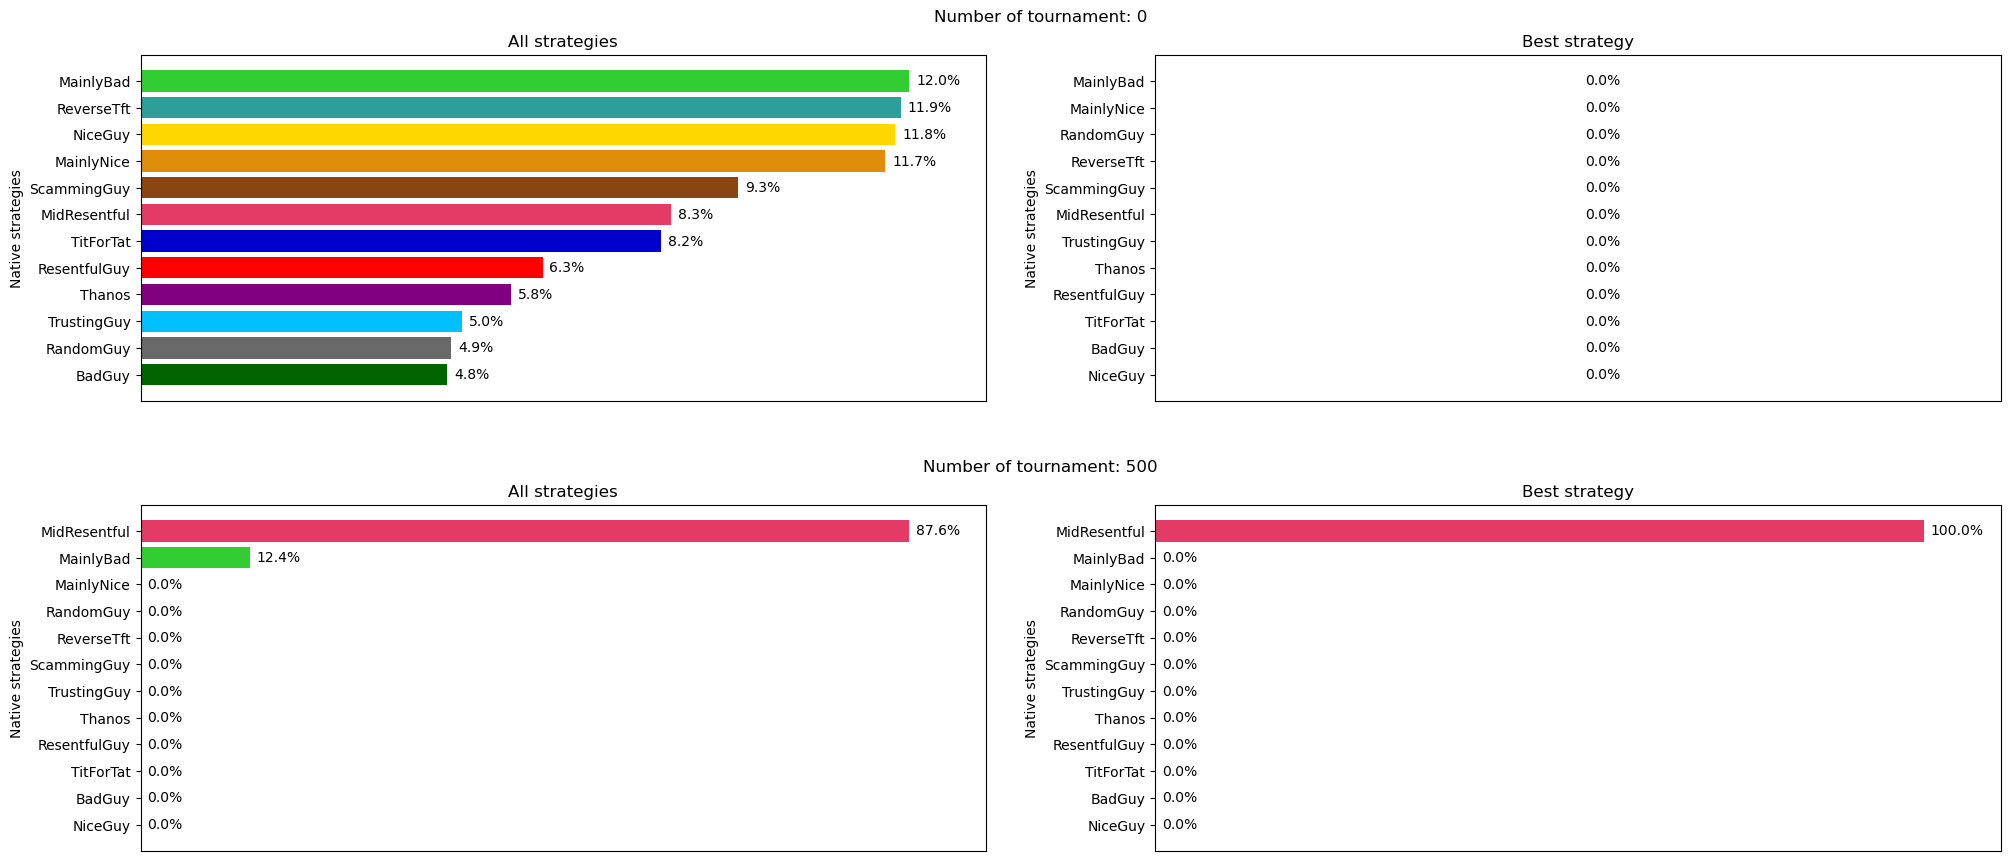

In [31]:
# ------------------------------ BASE GIF ------------------------------
make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'half_w', ], [ 'best_w', 'res_w', ],] ), 
           image_titles = [ ['All strategies', 'Top half strategies'], ['Best strategy', 'Strategy total results',] ], 
           gif_name = 'disney_500_iter_3_p', halo=True, every_n = 1,  n_interval = 500 )

# ------------------------------ 40 GIFS ------------------------------
# name_keys = np.asarray( [ str(i) for i in range( 40 ) ] ).reshape( 5, 8 )
# name_titles = np.asarray( [ f"Mutant number {i}/{len(mutant_list)}" for i in range( 40 ) ] ).reshape( 5, 8 )
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = name_keys, 
#            image_titles = name_titles, gif_name = 'BUHN_all')

# ------------------------------ 50 GIFS ------------------------------
# name_keys = np.asarray( [ str(i) for i in range( 50 ) ] ).reshape( 5, 10 )
# name_titles = np.asarray( [ f"Mutant number {i}/{len(mutant_list)}" for i in range( 50 ) ] ).reshape( 5, 10 )
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = name_keys, 
#            image_titles = name_titles, gif_name = 'Less_random_strat')

# ------------------------------ 30 GIFS ------------------------------
# name_keys = np.asarray( [ str(i) for i in range( 30 ) ] ).reshape( 6, 5 )
# name_titles = np.asarray( [ f"Mutant number {i}/{len(mutant_list)}" for i in range( 30 ) ] ).reshape( 6, 5 )
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = name_keys, 
#            image_titles = name_titles, gif_name = 'pod_gif_all')

# ------------------------------ 25 GIFS ------------------------------
# n_row, n_col = 5, 5
# name_keys = np.asarray( [ f"res_{i}" for i in range( n_row*n_col ) ] ).reshape( n_col, n_row )
# name_titles = np.asarray( [ f"Mutant classified {i+1}th/{len(mutant_list)}" for i in range( n_row*n_col ) ] ).reshape( n_col, n_row )
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = name_keys, 
#            image_titles = name_titles, gif_name = 'BUHN_results', y_label = f"Result fraction by strategy", fixed=True )

# ------------------------------ 25 GIFS ------------------------------
# n_row, n_col = 5, 5
# name_keys = np.asarray( [ f"res_{i}" for i in range( n_row*n_col ) ] ).reshape( n_col, n_row )
# name_titles = np.asarray( [ f"Mutant classified {i+1}th/{len(mutant_list)}" for i in range( n_row*n_col ) ] ).reshape( n_col, n_row )
# make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = name_keys, 
#            image_titles = name_titles, gif_name = 'BUHN_results', y_label = f"Result fraction by strategy", fixed=True )

# ------------------------------ BASE PNG ------------------------------
make_a_couple( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'total_w', 'best_w', ], ] ), 
           image_titles = [ ['All strategies', 'Best strategy',], ], file_name = 'disney_500_iter_3_p')


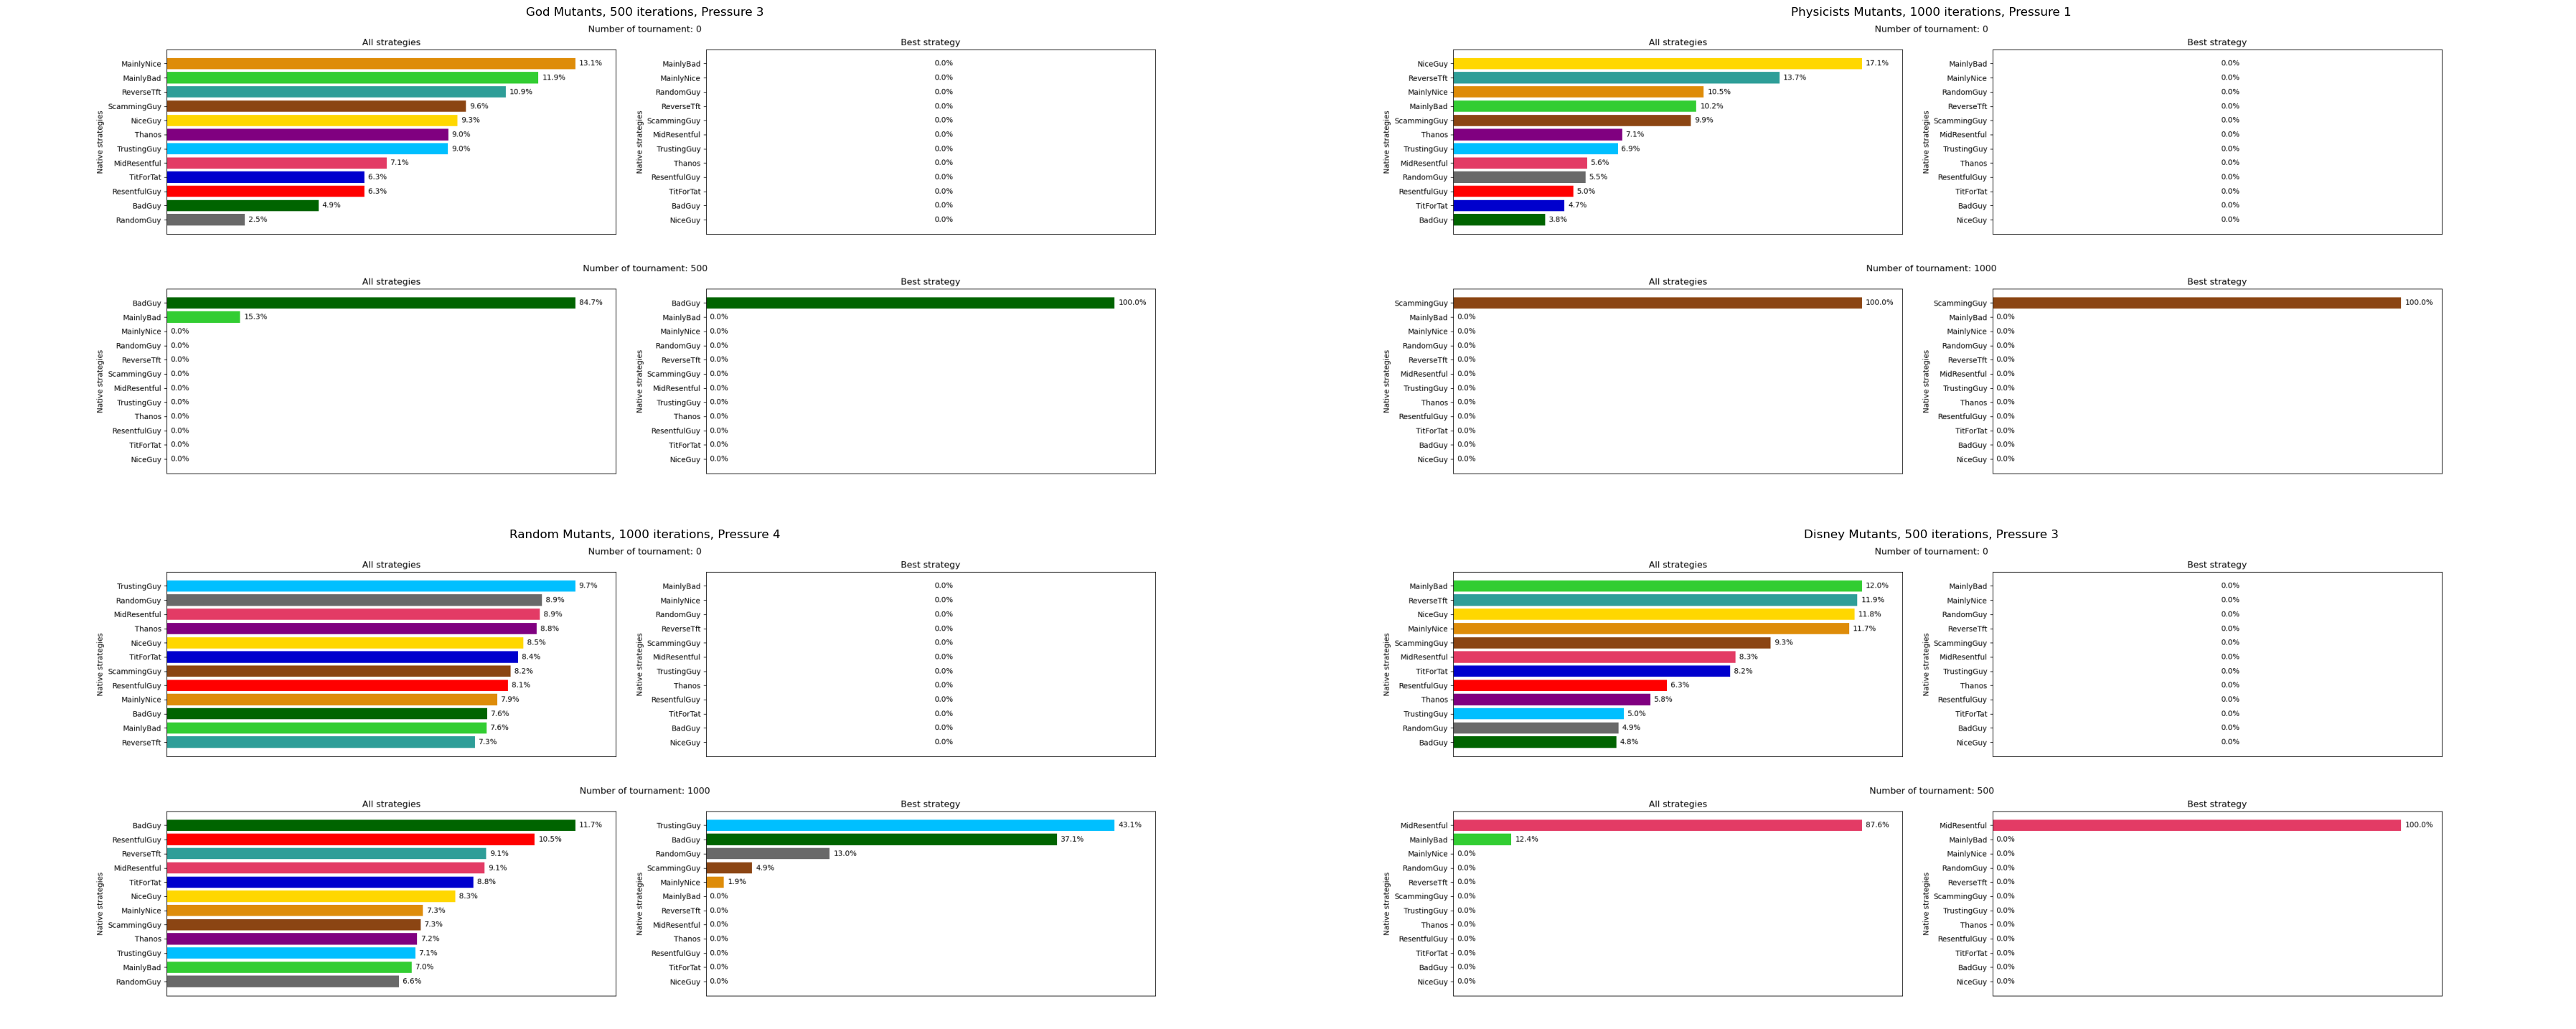

In [55]:
from matplotlib import image as mpimg

fig, axes = plt.subplots( 2, 2, figsize = ( 36, 15 ),  )
axes[0][0].imshow( mpimg.imread('god_500_iter_3_p.png') )
axes[0][0].set_title( 'God Mutants, 500 iterations, Pressure 3')
axes[0][0].axis('off')
axes[0][1].imshow( mpimg.imread('physicist_1000_iter_1_p.png') )
axes[0][1].set_title( 'Physicists Mutants, 1000 iterations, Pressure 1')
axes[0][1].axis('off')
axes[1][0].imshow( mpimg.imread('Shuffle_All_100_mut_1000_iter_4_p.png') )
axes[1][0].set_title( 'Random 100 Mutants, 1000 iterations, Pressure 4')
axes[1][0].axis('off')
axes[1][1].imshow( mpimg.imread('disney_500_iter_3_p.png') )
axes[1][1].set_title( 'Disney Mutants, 500 iterations, Pressure 3')
axes[1][1].axis('off')
fig.tight_layout()

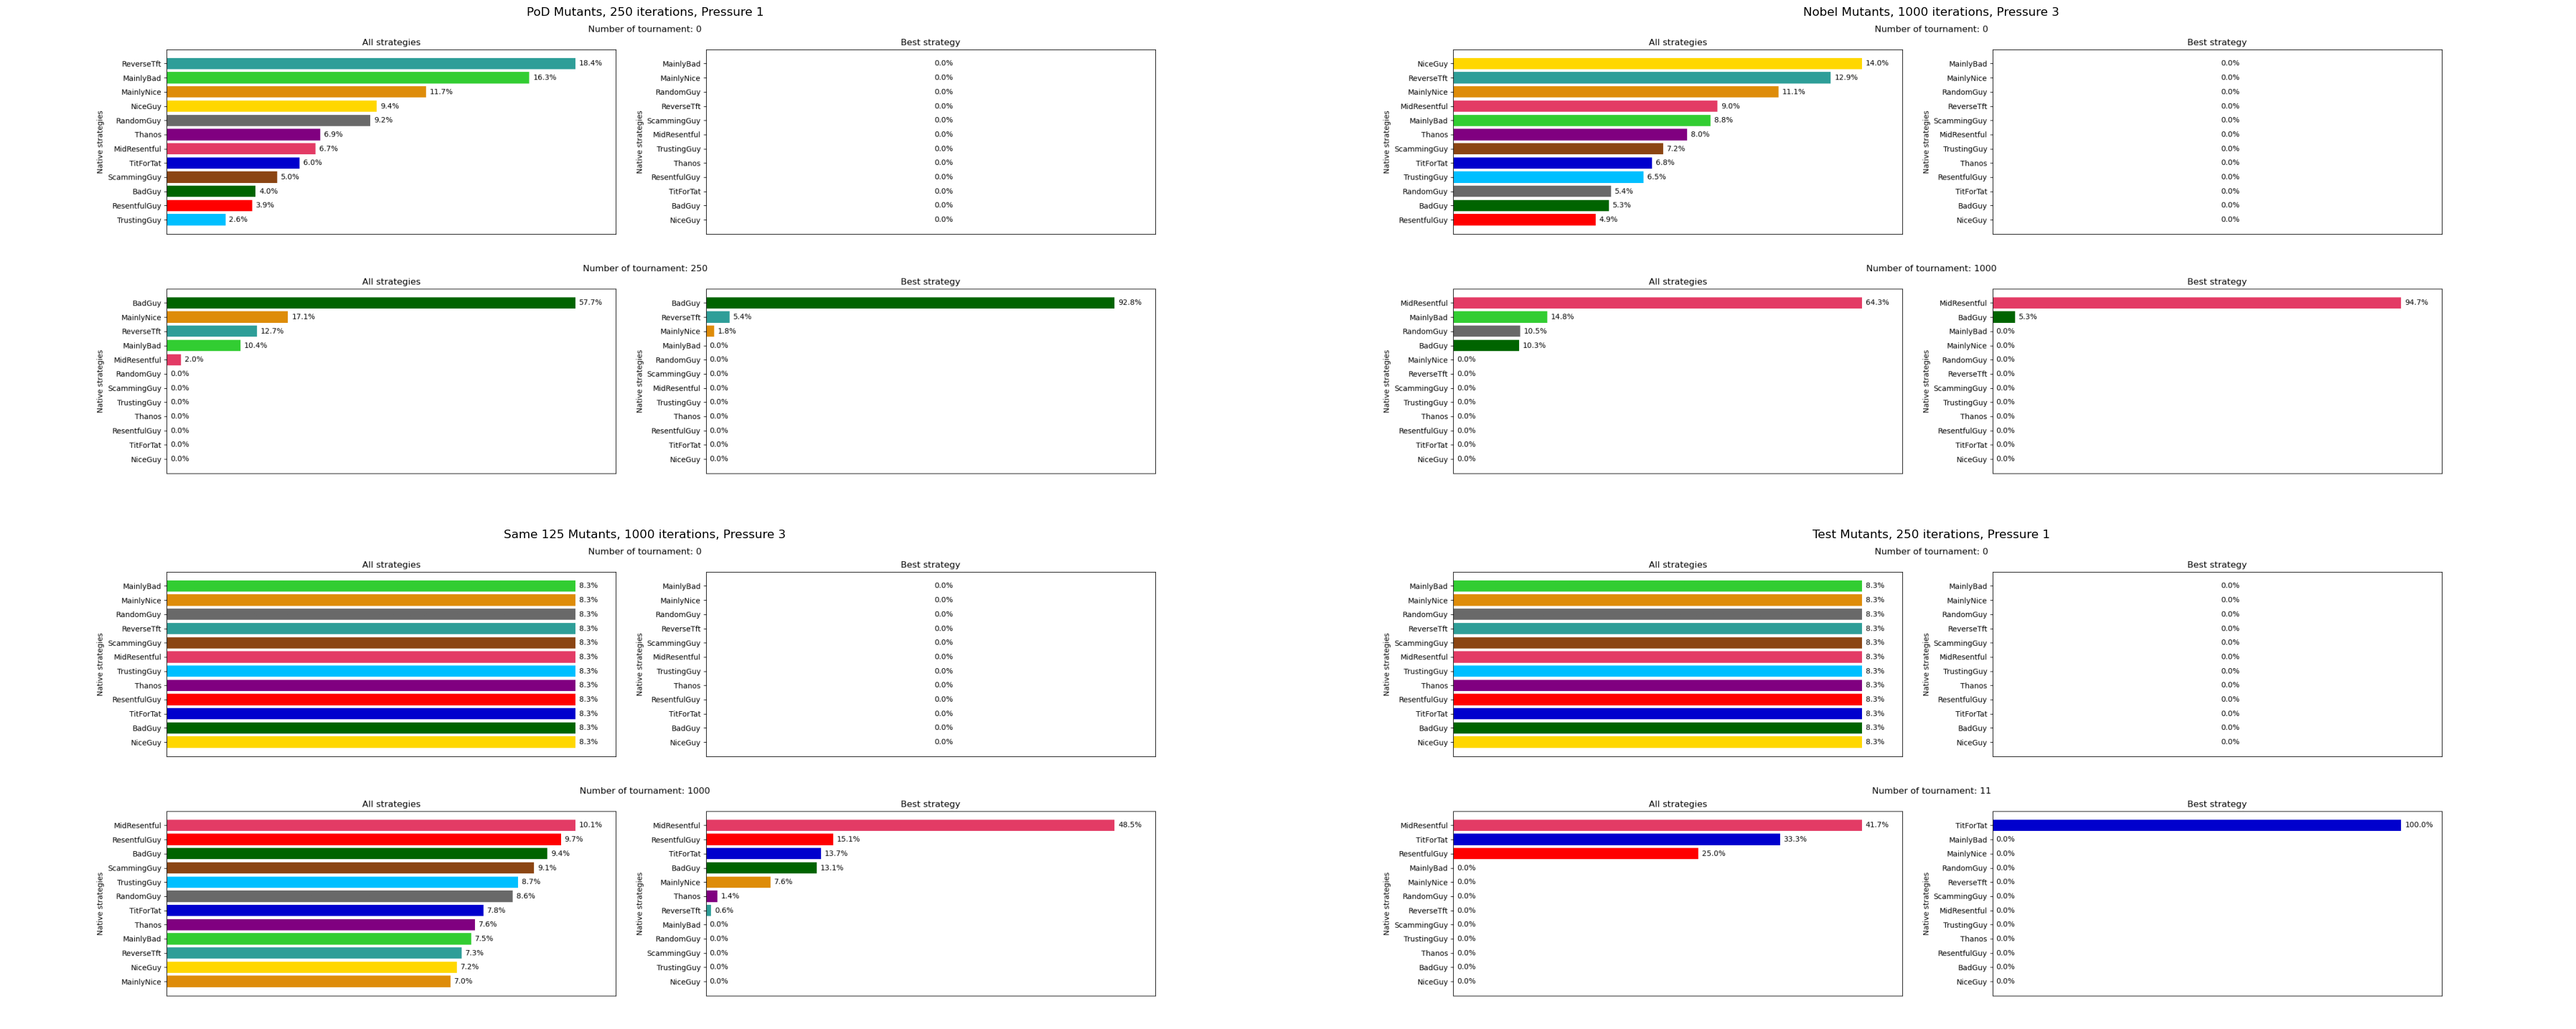

In [57]:
fig, axes = plt.subplots( 2, 2, figsize = ( 36, 15 ),  )
axes[0][0].imshow( mpimg.imread('PoD_250_iter_1_p.png') )
axes[0][0].set_title( 'PoD Mutants, 250 iterations, Pressure 1')
axes[0][0].axis('off')
axes[0][1].imshow( mpimg.imread('nobel_1000_iter_3_p.png') )
axes[0][1].set_title( 'Nobel Mutants, 1000 iterations, Pressure 3')
axes[0][1].axis('off')
axes[1][0].imshow( mpimg.imread('Same_All_125_mut_1000_iter_3_p.png') )
axes[1][0].set_title( 'Same 125 Mutants, 1000 iterations, Pressure 3')
axes[1][0].axis('off')
axes[1][1].imshow( mpimg.imread('test_250_iter_1_p.png') )
axes[1][1].set_title( 'Test Mutants, 250 iterations, Pressure 1')
axes[1][1].axis('off')
fig.tight_layout()

In [ ]:
# import imageio
# from IPython.display import HTML

# # opening an existing gif
# def gif_display( name, n_interval = 750 ) :
#     # import GIF file
#     gif = imageio.mimread( name, memtest=False )

#     # set the environmment
#     fig, ax = plt.subplots( figsize=(12,5)  )
#     # start the animation
#     img = ax.imshow(gif[0])

#     # update frames
#     def update( frame ) :
#         img.set_array( gif[ frame ] )
#         return [ img ]
        
#     #Animating frames
#     ani = animation.FuncAnimation(fig, update, frames=len(gif), interval=n_interval, repeat=True)

#     # close Matplotlib interace
#     plt.close()

#     # Actually display the animation
#     HTML(ani.to_jshtml())
    
# gif_display( 'physicist_1000_iter_1_p.gif' )

In [ ]:
# frames[ frames['tournament'] == 0 ]
# for c in strategies :
#     print(c)

In [ ]:
# import string
# default_dic = {
#         "gods" : ['ALATHANDER', 'BACCOB', 'BEORY', 'CELESTIAN', 'CORELLON_LARETHIAN', 'EHLONNA', 'ERYTHNUL', 'FHARLANGHN', 'HEIRONEOUS', 'HEXTOR', 'ISTUS', 'IUZ', 'JORAMY', 'KURELL', 'LENDOR', 'NERULL', 'OBAD-HAI', 'OLIDAMMARA', 'PELOR', 'PROCAN', 'RALISHAZ', 'RUDD', 'ST._CUTHBERT', 'TRITHEREON', 'VECNA', 'WAUKEEN',
#                 'AURIL', 'AZUTH', 'BANE', 'BHAAL', 'CHAUNTEA', 'CYRIC', 'DENEIR', 'ELDATH', 'GOND', 'HELM', 'ILMATER', 'KELEMVOR', 'LATHANDER', 'LEIRA', 'LLIIRA', 'LOVIATAR', 'MALAR', 'MASK', 'MIELIKKI', 'MILIL', 'MORADIN', 'MYRKUL', 'MYSTRA', 'OGHMA', 'SELUNE', 'SHAR', 'SHARESS', 'SHAUNDAKUL', 'SILVANUS', 'SUNE', 'TALONA', 'TALOS', 'TEMPUS', 'TORM', 'TYMORA', 'TYR', 'UMBERLEE', 'WAUKEEN',
#                 'CHEMOSH', 'GILEAN', 'HIDDUKEL', 'KIRI-JOLITH', 'MAJERE', 'MISHAKAL', 'MORGION', 'PALADINE', 'SARGONNAS', 'TAKHISIS', 'ZEBOIM',
#                 'AUREON', 'BALINOR', 'DOL_ARRAH', 'DOL_DORN', 'ARAWAI', 'BOLDREI', 'DEVICE', 'EBERRON', 'KORD', 'OLLADRA', 'ONATAR', 'THE_TRAVELER', 'THE_SHADOW',
#                 'ANUBIS', 'APOPHIS', 'BAST', 'HORUS', 'ISIS', 'RA', 'SET', 'SOBEK', 'THOTH',
#                 'APOLLO', 'ARES', 'ARTEMIS', 'ATHENA', 'DEMETER', 'DIONYSUS', 'HADES', 'HECATE', 'HELIOS', 'HERMES', 'POSEIDON', 'ZEUS',
#                 'AEGIR', 'BALDER', 'FORSETI', 'FREYA', 'FREY', 'HEIMDALL', 'HELA', 'LOKI', 'ODIN', 'THOR', 'TYR',
#                 'BLIBDOOLPOOLP', 'CORELLON_LARETHIAN', 'DEEP_SASHELAS', 'EADRO', 'GARL_GLITTERGOLD', 'GRUUMSH', 'HRUGGEK', 'KURTULMAK', 'LOLTH', 'MAGLUBIYET', 'MORADIN', 'RILLIFANE_RALLATHIL', 'SEHANINE_MOONBOW', 'SHEELA_PERYROYL', 'TIAMAT', 'YONDALLA'
#                 ],
#         "disney" : ['SNOW_WHITE', 'CINDERELLA', 'AURORA', 'ARIEL', 'BELLE', 'JASMINE', 'POCAHONTAS', 'MULAN', 'TIANA', 'RAPUNZEL', 'MERIDA', 'MOANA',
#                 'PRINCE_CHARMING', 'PRINCE_PHILLIP', 'ERIC', 'BEAST', 'ALADDIN', 'JOHN_SMITH', 'LI_SHANG', 'NAVEEN', 'FLYNN_RIDER', 'KRISTOFF',
#                 'WOODY', 'BUZZ_LIGHTYEAR', 'MIKE_WAZOWSKI', 'SULLEY', 'MR._INCREDIBLE', 'ELASTIGIRL', 'DORY', 'MARLIN', 'LIGHTNING_MCQUEEN', 'MERIDA', 'JOY', 'SADNESS', 'SOUL',
#                 'MICKEY_MOUSE', 'MINNIE_MOUSE', 'DONALD_DUCK', 'GOOFY', 'PLUTO', 'DAISY_DUCK',
#                 'MALEFICENT', 'URSULA', 'CRUELLA_DE_VIL', 'SCAR', 'JAFAR', 'CAPTAIN_HOOK', 'QUEEN_OF_HEARTS', 'GASTON', 'HADES', 'QUEEN_GRIMHILDE',
#                 'SIMBA', 'MUFASA', 'NALA', 'TIMON', 'PUMBAA', 'BAMBI', 'DUMBO', 'STITCH', 'LADY', 'TRAMP',
#                 'MUSHU', 'GENIE', 'SEBASTIAN', 'FLOUNDER', 'OLAF', 'PASCAL', 'RAJAH', 'MEEKO', 'ABU', 'LUMIERE', 'COGSWORTH'
#                 ],
#         "nobel" : ['MARTIN_LUTHER_KING_JR.', 'MOTHER_TERESA', 'NELSON_MANDELA', 'BARACK_OBAMA', 'DALAI_LAMA', 'MALALA_YOUSAFZAI', 'JIMMY_CARTER', 'DESMOND_TUTU', 'WANGARI_MAATHAI', 'HENRY_KISSINGER',
#                 'ALBERT_CAMUS', 'ERNEST_HEMINGWAY', 'GABRIEL_GARCÍA_MÁRQUEZ', 'TONI_MORRISON', 'PABLO_NERUDA', 'JEAN-PAUL_SARTRE', 'ALICE_MUNRO', 'BOB_DYLAN', 'KAZUO_ISHIGURO', 'MARIO_VARGAS_LLOSA',
#                 'ALBERT_EINSTEIN', 'MARIE_CURIE', 'RICHARD_FEYNMAN', 'STEPHEN_HAWKING', 'MAX_PLANCK', 'ENRICO_FERMI', 'WERNER_HEISENBERG', 'NIELS_BOHR', 'ERNEST_RUTHERFORD', 'PETER_HIGGS',
#                 'LINUS_PAULING', 'MARIE_CURIE', 'DMITRI_MENDELEEV', 'FRITZ_HABER', 'IRÈNE_JOLIOT-CURIE', 'ROSALIND_FRANKLIN', 'ADOLF_VON_BAEYER', 'HAROLD_UREY', 'AHMED_ZEWAIL', 'AARON_KLUG',
#                 'JONAS_SALK', 'ALEXANDER_FLEMING', 'WATSON_AND_CRICK', 'PAUL_EHRLICH', 'BARBARA_MCCLINTOCK', 'GERTRUDE_ELION', 'ELIZABETH_BLACKBURN', 'TU_YOUYOU', 'RALPH_STEINMAN', 'HERMANN_MULLER',
#                 'MILTON_FRIEDMAN', 'PAUL_KRUGMAN', 'JOSEPH_STIGLITZ', 'AMARTYA_SEN', 'GARY_BECKER', 'FREDERICK_HAYEK', 'DANIEL_KAHNEMAN', 'ROBERT_MERTON', 'VERNON_SMITH', 'OLIVER_WILLIAMSON'
#                 ],
#         "physicist" : ['ISAAC_NEWTON', 'GALILEO_GALILEI', 'JAMES_CLERK_MAXWELL', 'MICHAEL_FARADAY', 'DANIEL_BERNOULLI', 'HENRY_CAVENDISH', 'JOSEPH_PRIESTLEY', 'ANTOINE_LAVOISIER', 'JOSEPH_FOURIER', 'JOHANN_CARL_FRIEDRICH_GAUSS',
#                 'MAX_PLANCK', 'ALBERT_EINSTEIN', 'NIELS_BOHR', 'WERNER_HEISENBERG', 'ERWIN_SCHROEDINGER', 'WOLFGANG_PAULI', 'PAUL_DIRAC', 'LOUIS_DE_BROGLIE', 'RICHARD_FEYNMAN', 'MURRAY_GELL-MANN',
#                 'STEPHEN_HAWKING', 'MICHIO_KAKU', 'BRIAN_GREENE', 'LEONARD_SUSSKIND', 'CARLO_ROVELLI', 'PETER_HIGGS', 'EDWARD_WITTEN', 'ROGER_PENROSE', 'CARLO_RUBBIA', 'SHELDON_GLASHOW',
#                 'ENRICO_FERMI', 'MARIE_CURIE', 'ERNEST_RUTHERFORD', 'LISE_MEITNER', 'ARTHUR_COMPTON', 'OTTO_HAHN', 'GLENN_SEABORG', 'GEORGE_ANTON_OLAH', 'CLINTON_DAVISSON', 'ARTHUR_SCHAWLOW',
#                 'CARL_SAGAN', 'NEIL_DEGRASSE_TYSON', 'SUBRAHMANYAN_CHANDRASEKHAR', 'VERA_RUBIN', 'JOCELYN_BELL_BURNELL', 'STEPHEN_HAWKING', 'MARTIN_REES', 'KATI_MÓRÓ', 'DAN_HOOPER', 'JANNA_LEVIN',
#                 'JENNIFER_DOUDNA', 'KIMBERLY_BRYANT', 'DONNA_STRICKLAND', 'ANDREA_GHEZ', 'FRANÇOISE_BARRÉ-SINOUSSI', 'EMMANUELLE_CHARPENTIER', 'MARGARET_MURNANE', 'DONNA_STRICKLAND', 'FABIOLA_GIANOTTI', 'SARA_SEAGER', 'MARCO_ZANETTI'
#                 ],
#         "pod" : [ 'LENA_MARGHERITA', 'DI_LUCIA_SOFIA', 'CAVALLIN_JONATHAN', 'POCCIANI_GABRIELE', 'PONCHIO_MATTIA', 'CAFAGNO_SAMUELE',
#                   'BROCCO_LUCA', 'PIRAZZO_TOMMASO', 'PIERIPOLLI_LEONARDO', 'SCHIAVINATO_ALBERTO', 'BELLI_LUIGI', 'TAMARIN_CHIARA', 'TUSCANO_ALESSIO',
#                   'BORTOLATO_ANGELA', 'SECCO_BENEDETTO', 'NAPOLEONE_GIOVANNI', 'BEZZI_FILIPPO', 'CONTE_WILLIAM', 'FASIOLO_GIORGIA', 'GASPAROTTO_GIACOMO',
#                   'EDOARDO_D_AMORE', 'ZARA_MIRIAM', 'CORTE_RICCARDO', 'JAMILOV_JAVLONBEK', 'BEATRICE_BERGAMIN',
#                 ],
#         "test" : [ 'NNNB', 'BBBN', 'UUB', 'NNU', 'RNN', 'URR', 'BRU'],
#     }
# ucs = string.ascii_uppercase
# something = { key : np.sort( np.asarray( [ sum( [ float( name.count( l ) ) / len( name ) for name in default_dic[key] ] ) for l in ucs ] ) ) for key in default_dic }
# g = [ 'L', 'O', 'R', 'S', 'I', 'T' 'N']
# g = list(mutant.genes.keys())
# for key in default_dic :
#     print( key )
#     for name in default_dic[key] :
#         if( np.all( np.asarray( [ i not in g for i in name ] ) ) ) :
#             print( name )
# for key in default_dic:
#     print( key )
#     count =  sorted( [ ( l, sum( [ float( name.count( l ) * 100 ) / ( len( name ) * len( default_dic[key] ) ) for name in default_dic[key] ] ) ) for l in ucs ], reverse = True,  key=lambda x: x[1])
#     for c in count : 
#         # if ( c[0] in g ) :
#         if( c[1] < 15 and c[1] > 1 ) :
#               print( c )
# for k in something:
#     print( k, something[k])

In [ ]:
# st = [ ( 'Thanos', 0.3 ), ( 'TitForTat', 0.7 ), ( 'NiceGuy', 1.) ]
# dic = { i : strategies[st[i][0]] for i in range(len(st)) }
# if ( not ( bad_guy in dic.values() ) ) : dic[ len(dic) ] = bad_guy
# print([ (i, dic[i])  for i in dic ])
# print( sum( np.array( [ 0.1, 0.5, 0.3 ] ) ) )

# import copy
# user = mutant( 'user', [ ( 'NiceGuy', 0.2 ), ( 'TitForTat', 0.5 ), ( 'Thanos', 0.1 ) ] )

# copy method
# unuser = copy.deepcopy( user )
# unuser.mutate()
# unuser.name = 'unuser'

# print( user )
# print( unuser )
# print( [ user.move() for i in range(10) ] )
# print( tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) )
# print( list(strategies.keys())[0] )

#test with dictionary
# for i in range(10) : user.mutate()
# strategies[ 'user' ] = user.move

# mutate and move test
# for i in range(10) :
#     user.mutate()
#     print(user, user.move( ))
# for i in range(10) :
#     user.mutate()
#     print(user, user.move( ))

# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)

# print(user)
# print(unuser)

# for i in range(100):
#     user.mutate()
#     unuser.mutate()

# print(user)
# print(unuser)

# gen = mutant.from_genome( "NNNBBURSI0" )
# gen.mutate()
# print( gen )
# print( gen.genome( 30 ) )

# A = mutant.from_genome( "B" )
# B = mutant.from_genome( "N" )
# C = mutant.from_genome( "U" )
# A.mutate()
# B.mutate()
# C.mutate()
# print( A, B, C )
# strategies[ A.name ] = A.move
# strategies[ B.name ] = B.move
# strategies[ C.name ] = C.move
# print( m_tourney( player_list=[ A.name, B.name, C.name], N_rounds = 10, M = Payoff ) )
# del strategies[ A.name ]
# del strategies[ B.name ]
# del strategies[ C.name ]

# normal_names = list( mutant.genes.keys() )
# normal_names.remove( 'S' )
# normal_names.remove( 'F' )
# normals = [ mutant.from_genome( g ) for g in normal_names ]
# [print(n) for n in normals ]
# for n in normals :
#     strategies[ n.name ] = n.move
# result = m_tourney( player_list=normal_names, N_rounds = 10, M = Payoff )
# #for item in result: print(item)
# print("\nHere's the Ranking at the end of the tourney:")
# # Sorted gives a copy, while using LIST.sort() does it in place.
# Ranking = sorted(result,reverse=True, key=lambda x: x[1])
# for item in Ranking: print(item)
# for n in normals :
#     del strategies[ n.name ]
# print(list(strategies.keys()))


# print ( match( 'NiceGuy', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'BadGuy', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'ResentfulGuy', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'MainlyNice', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'TitForTat', 'ScammingGuy', N_rounds = 10, M = Payoff ) )


# strategies[ gen.name ] = gen.move
# print(  match( gen.name, 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# for i in range( 10 ) : gen.mutate()
# print(  match( gen.name, 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print( match( 'user', 'BadGuy', 20, M = Payoff ) )
# del strategies[ 'user' ]
# print( [ i for i in strategies ] )

# ('BadGuy1', 106)
# ('ResentfulGuy1', 103)
# ('MidResentful1', 97)
# ('TitForTat1', 91)
# ('Thanos1', 82)
# ('NiceGuy1', 76.0)
# ('ReverseTft1', 76.0)
# r_genomes = np.array( [ np.array( [ 'A', 'N', 'B', 'R' ] ), np.array( [ 'I', 'U', 'T', 'S' ] ) ])
# genomes = [ ''.join(g) for g in r_genomes ]
# for i in genomes : print( i )
# mutant_list , name_list = get_m_list( "physicist" )
# mutant_list , name_list = get_m_list( "test" )
# classification = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=20, pressure = 2,  M = Payoff )
# print( classification )
# for mut in mutant_list : print(mut)
# for game in classification :
#     print("\nNew Game\n")
#     for player in game : 
#         print(player)
# print( mutant_list[ classification[-1][0][0] ] )